In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

donations = pd.read_csv('donations.csv')
essays = pd.read_csv('essays.csv')
outcomes = pd.read_csv('outcomes.csv')
projects = pd.read_csv('projects.csv')
resources = pd.read_csv('resources.csv')

## if running from colab
# from google.colab import drive
# drive.mount('/content/drive')
# donations = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/donations.csv')
# essays = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/essays.csv')
# outcomes = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/outcomes.csv')
# projects = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/projects.csv')
# resources = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/resources.csv')


In [112]:
# merge projects
df = projects.merge(outcomes[['projectid', 'fully_funded']], on='projectid', how='left')

# merge essays
df = df.merge(essays[['projectid', 'title', 'short_description', 'need_statement', 'essay']], on='projectid', how='left')

# Aggregate resources
resources_summary = resources.groupby('projectid').agg({
    'item_unit_price': ['sum', 'mean', 'max'],
    'item_quantity': ['sum', 'mean'],
    'project_resource_type': pd.Series.nunique
})
resources_summary.columns = [
    'resource_cost_sum', 'resource_price_avg', 'resource_price_max',
    'item_quantity_sum', 'item_quantity_avg', 'resource_type_count'
]
resources_summary = resources_summary.reset_index()
#merge resources
df = df.merge(resources_summary, on='projectid', how='left')

In [113]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,title,short_description,need_statement,essay,resource_cost_sum,resource_price_avg,resource_price_max,item_quantity_sum,item_quantity_avg,resource_type_count
0,316ed8fb3b81402ff6ac8f721bb31192,42d43fa6f37314365d08692e08680973,c0e6ce89b244764085691a1b8e28cb81,6.362701e+10,36.576340,-119.608713,Selma,CA,93662.0,NaN,...,Multiculturalism in Literacy,Can we read one more chapter? Do we have to go...,My students need 3 novel sets with multicultur...,Can we read one more chapter? Do we have to go...,14.40,4.80,5.10,99.0,33.00,1.0
1,90de744e368a7e4883223ca49318ae30,864eb466462bf704bf7a16a585ef296a,d711e47810900c96f26a5d0be30c446d,4.837020e+11,32.911179,-96.723640,Dallas,TX,75243.0,urban,...,Reading is the Window to the World!,Engaging reading materials sent right to my st...,My students need exciting reading materials li...,Engaging reading materials sent right to my st...,83.44,10.43,47.32,50.0,6.25,1.0
2,32943bb1063267de6ed19fc0ceb4b9a7,37f85135259ece793213aca9d8765542,665c3613013ba0a66e3a2a26b89f1b68,4.103270e+11,45.166039,-122.414576,Colton,OR,97017.0,rural,...,A Little Tech Goes A Long Way,Our second grade in rural Oregon is an adventu...,My students need an iPad Mini.,Our second grade in rural Oregon is an adventu...,379.99,379.99,379.99,1.0,1.00,1.0
3,bb18f409abda2f264d5acda8cab577a9,2133fc46f951f1e7d60645b0f9e48a6c,4f12c3fa0c1cce823c7ba1df57e90ccb,3.600153e+11,40.641727,-73.965655,Brooklyn,NY,11226.0,urban,...,"Provide Content Aligned, Leveled Texts, For Sc...",Help give 12 Brooklyn students access and orga...,My students need social studies literature res...,Help give 12 Brooklyn students access and orga...,538.00,269.00,329.00,2.0,1.00,1.0
4,24761b686e18e5eace634607acbcc19f,867ff478a63f5457eaf41049536c47cd,10179fd362d7b8cf0e89baa1ca3025bb,6.227100e+10,34.043939,-118.288371,Los Angeles,CA,90006.0,urban,...,Multi-Media Cart,Technology is changing the world as we speak. ...,My students need a multi-media workstation car...,Technology is changing the world as we speak. ...,341.98,170.99,278.99,2.0,1.00,1.0


In [114]:
# aggregate donations
donations_agg = donations.groupby('projectid').agg({
    'donor_acctid': 'nunique',        
    'donationid': 'count'              
}).reset_index()

donations_agg = donations_agg.rename(columns={
    'donor_acctid': 'num_unique_donors',
    'donationid': 'donation_counts'
})

# 2. Merge donations
df = df.merge(donations_agg, on='projectid', how='left')

# Drop columns with too many missing values
missing_pct = df.isnull().mean().sort_values(ascending=False)
cols_to_drop = missing_pct[missing_pct > 0.4].index
df = df.drop(columns=cols_to_drop)

# Drop rows with missing labels
df = df.dropna(subset=['fully_funded'])


# Fill other NaNs with median
df = df.fillna({
    'students_reached': df['students_reached'].median(),
    'total_price_including_optional_support': df['total_price_including_optional_support'].median()
})

# text features 
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')
df['essay_length'] = df['essay'].astype(str).apply(len)
df['title_length'] = df['title'].astype(str).apply(len)
df['need_statement_length'] = df['need_statement'].astype(str).apply(len)
df['short_description_length'] = df['short_description'].astype(str).apply(len)

df['month_posted'] = df['date_posted'].dt.month
df['year_posted'] = df['date_posted'].dt.year
df['fully_funded_bin'] = df['fully_funded'].map({'t': 1, 'f': 0})


df = df[df['school_state'].isin(['NM','MI','UT','AZ','HI','CT','AA','WA','GA','OK','AE','CO','SC','TX'])]
df.to_csv('df.csv', index=False)
print(df.shape)
print(df.columns.tolist())
print(df['projectid'].is_unique)
df.columns.to_list()


(139377, 55)
['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_state', 'school_zip', 'school_metro', 'school_district', 'school_county', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_prefix', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'fulfillment_labor_materials', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'date_posted', 'fully_funded', 'title', 'short_description', 'need_statement', 'essay', 'resource_cost_sum', 'resource_price_avg', 'resource_price_max', 'item_quantity_sum', 'item_quantity_avg', 'resource_type_count', 'num_unique_donors', 'donati

['projectid',
 'teacher_acctid',
 'schoolid',
 'school_ncesid',
 'school_latitude',
 'school_longitude',
 'school_city',
 'school_state',
 'school_zip',
 'school_metro',
 'school_district',
 'school_county',
 'school_charter',
 'school_magnet',
 'school_year_round',
 'school_nlns',
 'school_kipp',
 'school_charter_ready_promise',
 'teacher_prefix',
 'teacher_teach_for_america',
 'teacher_ny_teaching_fellow',
 'primary_focus_subject',
 'primary_focus_area',
 'secondary_focus_subject',
 'secondary_focus_area',
 'resource_type',
 'poverty_level',
 'grade_level',
 'fulfillment_labor_materials',
 'total_price_excluding_optional_support',
 'total_price_including_optional_support',
 'students_reached',
 'eligible_double_your_impact_match',
 'eligible_almost_home_match',
 'date_posted',
 'fully_funded',
 'title',
 'short_description',
 'need_statement',
 'essay',
 'resource_cost_sum',
 'resource_price_avg',
 'resource_price_max',
 'item_quantity_sum',
 'item_quantity_avg',
 'resource_type_coun

In [115]:
print("Number of projects:", df.shape[0])
print("Columns:", df.shape[1])
print(df['fully_funded'].value_counts(normalize=True))


Number of projects: 139377
Columns: 55
fully_funded
t    0.670541
f    0.329459
Name: proportion, dtype: float64


In [116]:
print("Poverty level")
print(df['poverty_level'].value_counts())

print("\nGrade level")
print(df['grade_level'].value_counts())

print("\nSubject")
print(df['primary_focus_area'].value_counts())

print("\nStates")
print(df['school_state'].value_counts().head(10))


Poverty level
poverty_level
highest poverty     72324
high poverty        42605
moderate poverty    21588
low poverty          2860
Name: count, dtype: int64

Grade level
grade_level
Grades PreK-2    53590
Grades 3-5       46081
Grades 6-8       21700
Grades 9-12      18004
Name: count, dtype: int64

Subject
primary_focus_area
Literacy & Language    62727
Math & Science         36835
Music & The Arts       12099
Applied Learning       10342
Special Needs           7991
History & Civics        5882
Health & Sports         3492
Name: count, dtype: int64

States
school_state
TX    37200
SC    17587
OK    14101
GA    13736
MI    11019
WA     9714
AZ     8942
UT     8703
CT     7146
CO     6475
Name: count, dtype: int64


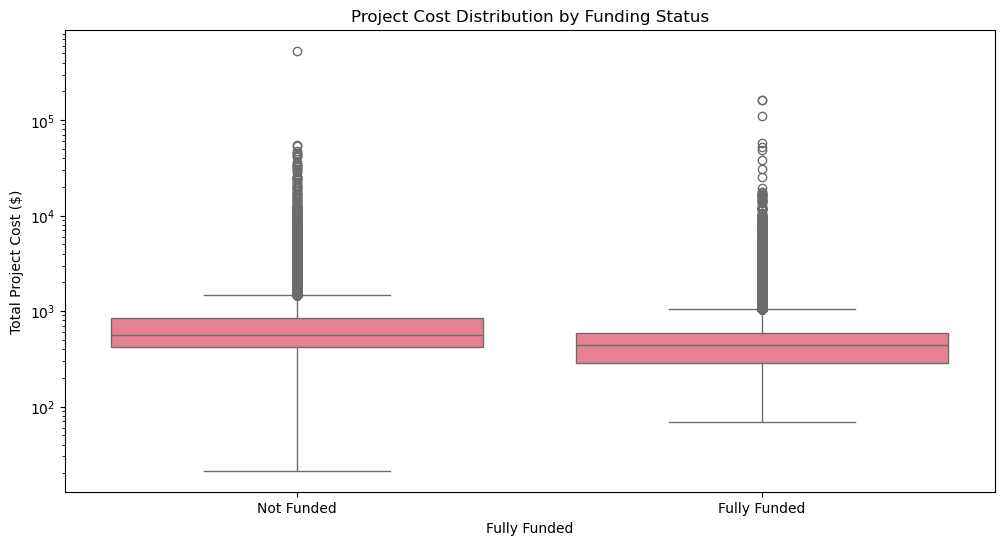

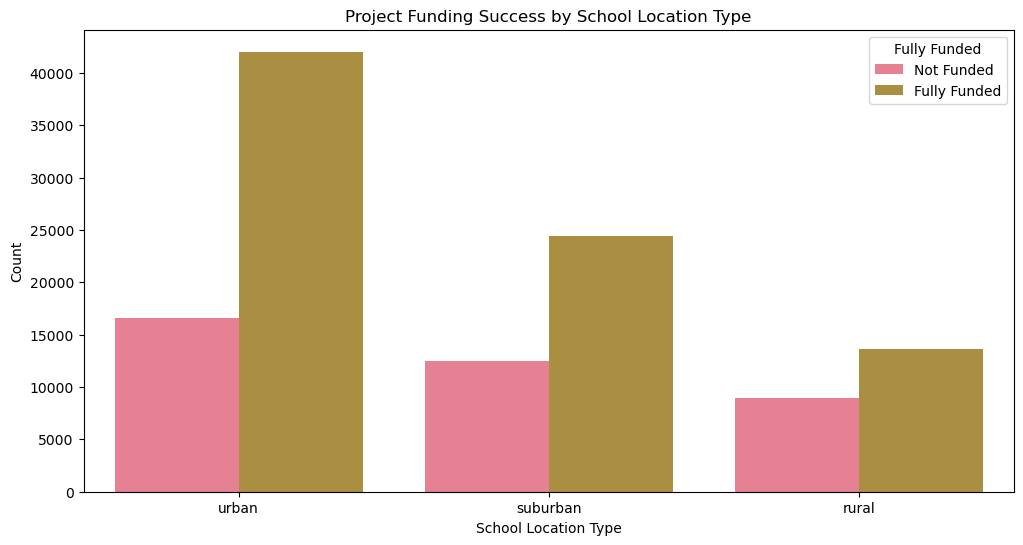

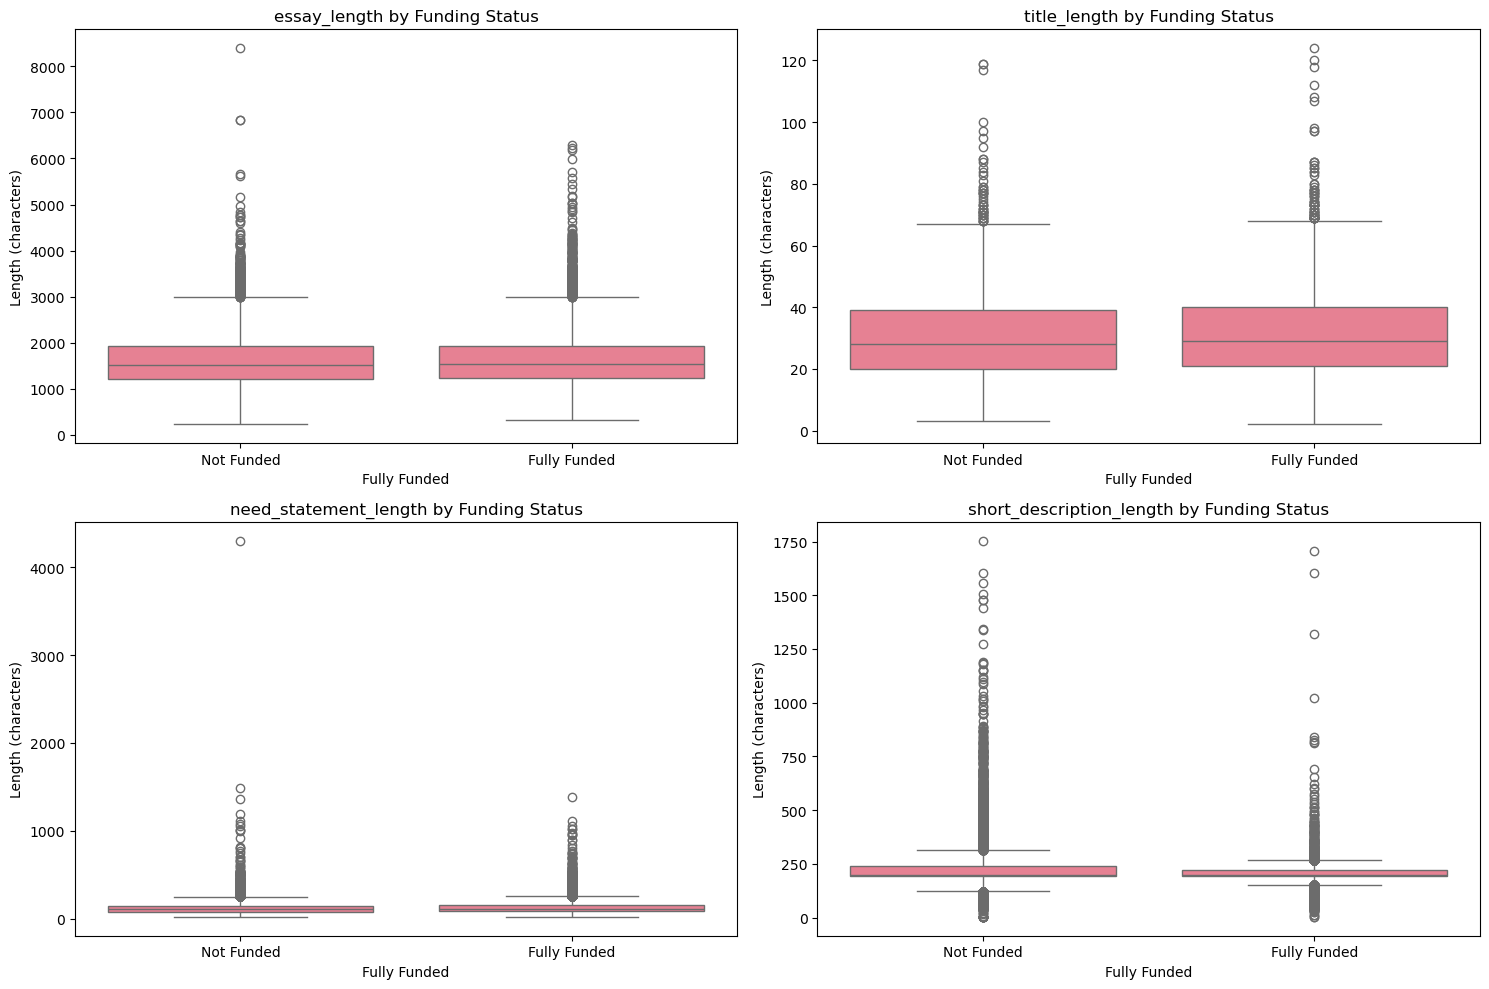

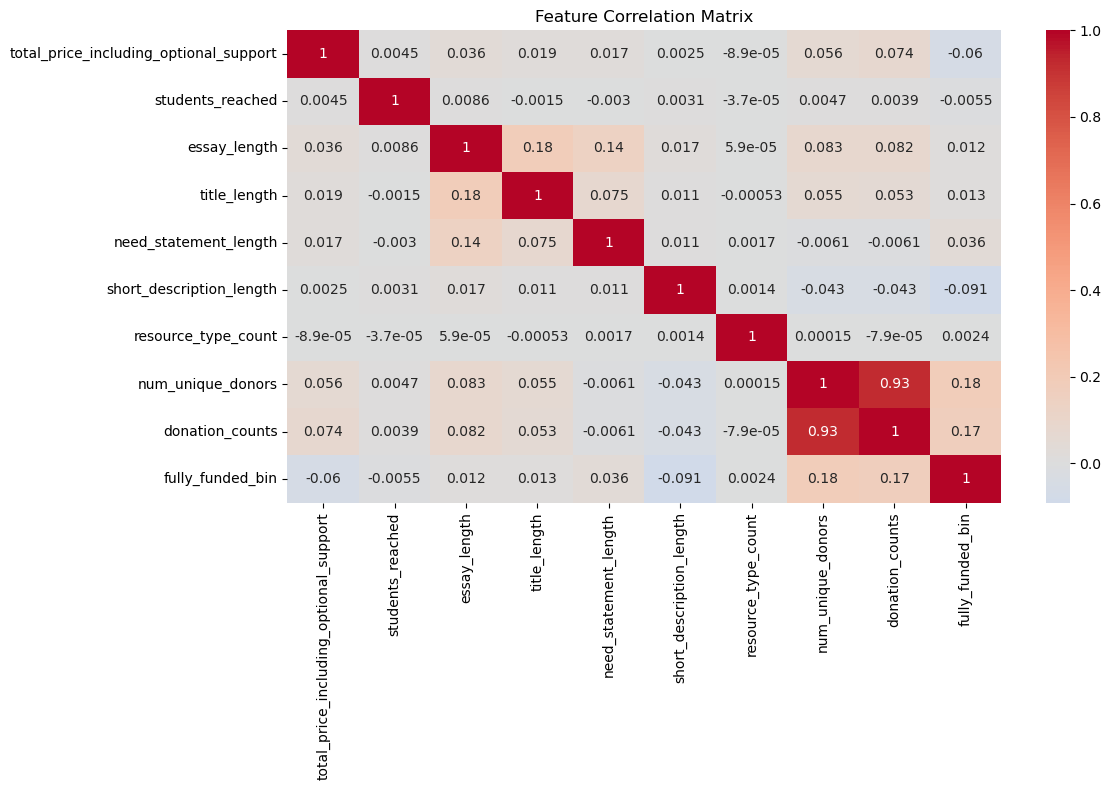

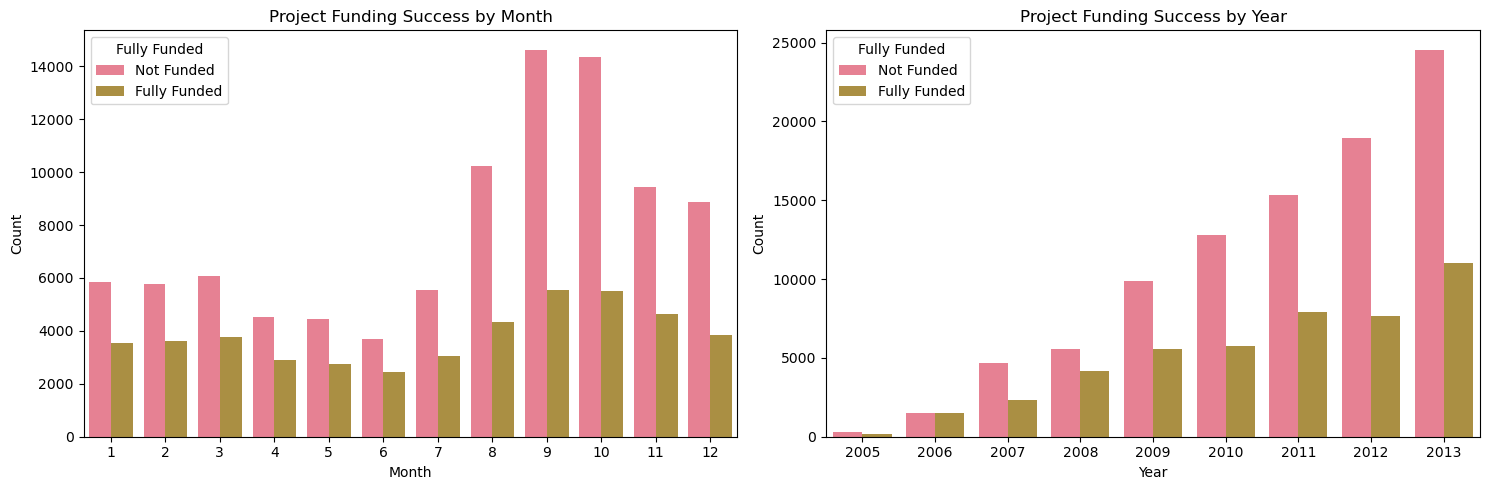

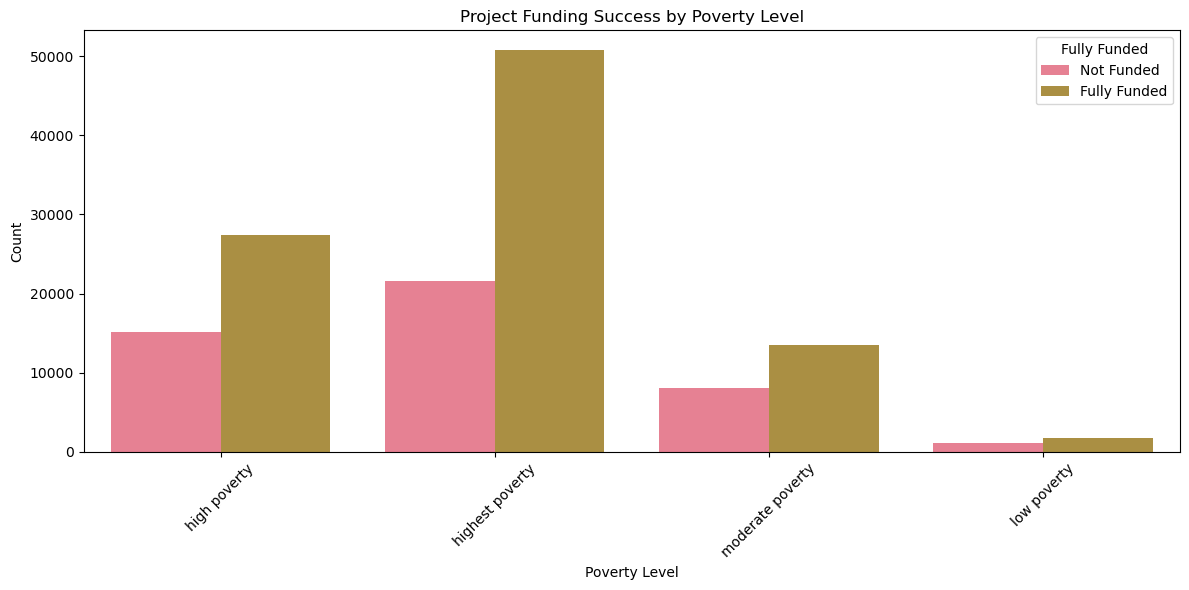

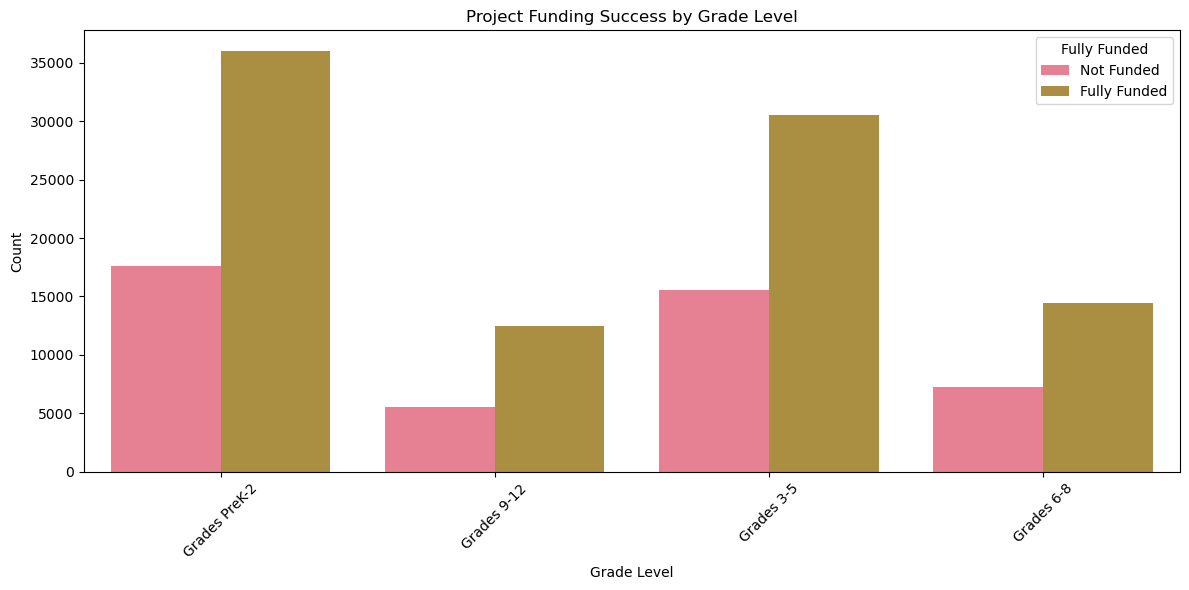

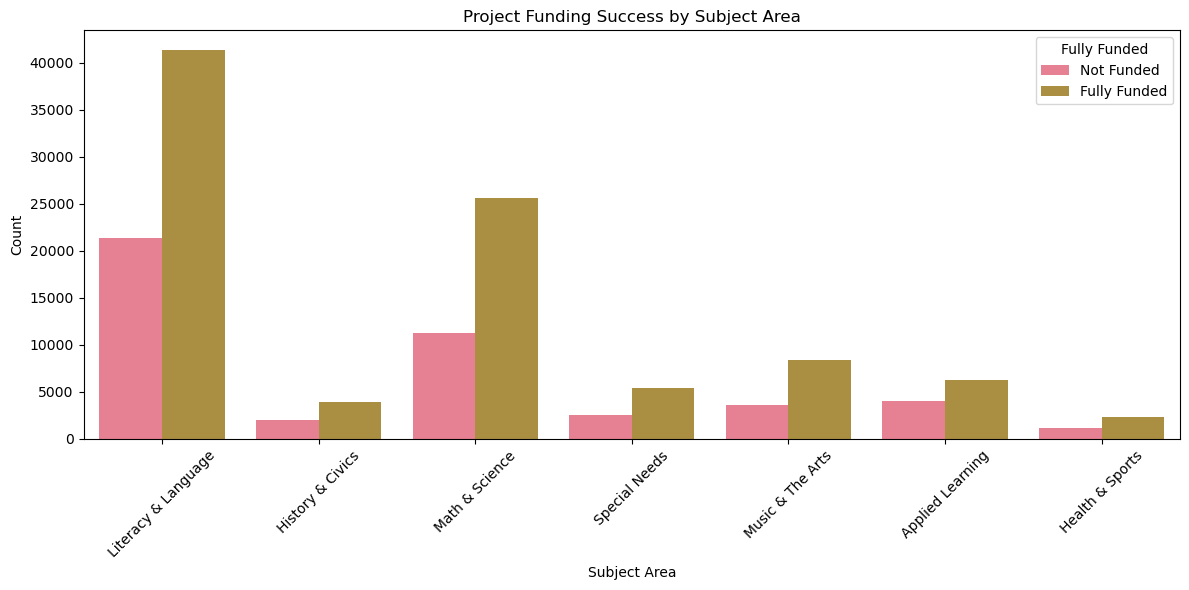

In [117]:
# ============ EDA: Feature Analysis ============

plt.style.use('default')
sns.set_palette("husl")

#  Project Cost Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='fully_funded', y='total_price_including_optional_support', data=df)
plt.title('Project Cost Distribution by Funding Status')
plt.xlabel('Fully Funded')
plt.ylabel('Total Project Cost ($)')
plt.xticks([0, 1], ['Not Funded', 'Fully Funded'])
plt.yscale('log')
plt.show()

# School Location Impact
plt.figure(figsize=(12, 6))
sns.countplot(x='school_metro', hue='fully_funded', data=df)
plt.title('Project Funding Success by School Location Type')
plt.xlabel('School Location Type')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])
plt.show()

# Text Length Analysis
text_features = ['essay_length', 'title_length', 'need_statement_length', 'short_description_length']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(text_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='fully_funded', y=feature, data=df)
    plt.title(f'{feature} by Funding Status')
    plt.xlabel('Fully Funded')
    plt.ylabel('Length (characters)')
    plt.xticks([0, 1], ['Not Funded', 'Fully Funded'])
plt.tight_layout()
plt.show()


# Correlation Analysis
numeric_features = ['total_price_including_optional_support', 'students_reached', 
                   'essay_length', 'title_length', 'need_statement_length', 
                   'short_description_length', 'resource_type_count', 
                   'num_unique_donors', 'donation_counts']

correlation_matrix = df[numeric_features + ['fully_funded_bin']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


# Time-based Analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='month_posted', hue='fully_funded', data=df)
plt.title('Project Funding Success by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])

plt.subplot(1, 2, 2)
sns.countplot(x='year_posted', hue='fully_funded', data=df)
plt.title('Project Funding Success by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])
plt.tight_layout()
plt.show()

# Poverty Level Analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='poverty_level', hue='fully_funded', data=df)
plt.title('Project Funding Success by Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grade Level Analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='grade_level', hue='fully_funded', data=df)
plt.title('Project Funding Success by Grade Level')
plt.xlabel('Grade Level')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Subject Area Analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='primary_focus_area', hue='fully_funded', data=df)
plt.title('Project Funding Success by Subject Area')
plt.xlabel('Subject Area')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Cosine Similarity on TF-IDF vectors
## To find Correlation between columns: title, short_description, need_statement, essay

title vs short_description: 0.0186
title vs need_statement: 0.0171
title vs essay: 0.0602
short_description vs need_statement: 0.0237
short_description vs essay: 0.0578
need_statement vs essay: 0.0611
                      title  short_description  need_statement     essay
title              1.000000           0.017027        0.077823  0.188479
short_description  0.017027           1.000000        0.010214  0.018237
need_statement     0.077823           0.010214        1.000000  0.138283
essay              0.188479           0.018237        0.138283  1.000000


/var/folders/yt/r5wgtmb12n17g42ykp7839w00000gn/T/ipykernel_77661/795743391.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  text = sample_df[['title', 'short_description', 'need_statement', 'essay']].applymap(lambda x: len(str(x)))


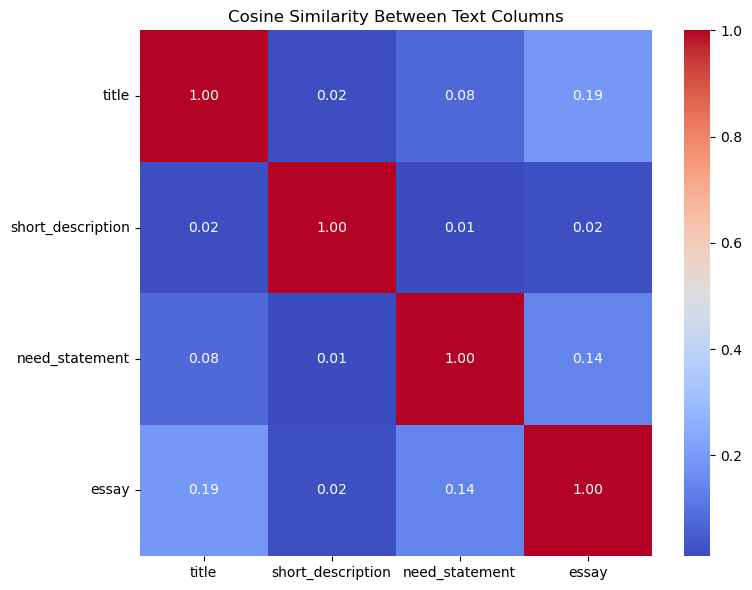

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#To avoid the kernel from dying we are just sampling 15,000 rows to analyse our similarity

sample_df = df[['title', 'short_description', 'need_statement', 'essay']].fillna('').sample(15000, random_state=42)

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Create a dictionary to hold similarity scores
similarity_results = {}

# Loop through each pair of columns
columns = sample_df.columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1, col2 = columns[i], columns[j]
        
        # Combine the two columns' text
        combined_text = sample_df[col1] + " " + sample_df[col2]
        
        # Fit and transform TF-IDF
        tfidf_matrix = vectorizer.fit_transform(combined_text)
        
        # Compute average cosine similarity between col1 and col2
        sim_matrix = cosine_similarity(tfidf_matrix)
        avg_similarity = sim_matrix.mean()
        
        similarity_results[f"{col1} vs {col2}"] = avg_similarity

# Display results
for pair, score in similarity_results.items():
    print(f"{pair}: {score:.4f}")

#Finding Correlation

text = sample_df[['title', 'short_description', 'need_statement', 'essay']].applymap(lambda x: len(str(x)))
correl_matrix = text.corr()
print(correl_matrix)

#Plot heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(correl_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cosine Similarity Between Text Columns')
plt.tight_layout()
plt.show()

## Features

In [119]:

# features
all_feature_cols = [
    # These are the ones I had before
    'total_price_including_optional_support',
    'essay_length',
    'need_statement_length',
    'poverty_level',
    'students_reached',
    'month_posted',
    'school_state',

    # These are the features we had for our merged_dataset. I dropped some columns such as 'projectid', 'teacher_acctid', 'schoolid', 'donor_acctid' since they don't 
    # help with our models. There are also a few columns that are in the merged_dataset but i didn't find them: 
    # ['at_least_1_teacher_referred_donor', 'at_least_1_green_donation', 'great_chat', 'three_or_more_non_teacher_referred_donors', 
    # 'one_non_teacher_referred_donor_giving_100_plus', 'donation_from_thoughtful_donor', 'great_messages_proportion', 'teacher_referred_count', 
    # 'non_teacher_referred_count']
    'resource_type',
    'donation_counts',
]

# Drop rows with missing required values
df_model = df[all_feature_cols + ['fully_funded_bin']].dropna()

# Define X and y
X = df_model[all_feature_cols]
y = df_model['fully_funded_bin']

df_model.to_csv('feature_matrix.csv', index=False)

print(df_model.shape)
df_model.to_csv('feature_matrix.csv', index=False)
df_model


(115918, 10)


,total_price_including_optional_support,essay_length,need_statement_length,poverty_level,students_reached,month_posted,school_state,resource_type,donation_counts,fully_funded_bin
44777,809.54,1118,93,high poverty,22.0,12,SC,Supplies,2.0,0
44784,610.62,1047,50,highest poverty,160.0,12,NM,Technology,4.0,1
44789,937.85,1951,166,high poverty,24.0,12,TX,Technology,15.0,1
44791,430.22,2362,86,highest poverty,19.0,12,CO,Technology,8.0,1
44801,511.64,1784,126,moderate poverty,15.0,12,AZ,Supplies,19.0,1
...,...,...,...,...,...,...,...,...,...,...
653144,1962.50,1305,276,moderate poverty,20.0,8,SC,Books,1.0,0
653157,2148.76,1537,73,highest poverty,40.0,8,SC,Technology,1.0,1
653195,436.59,1247,132,moderate poverty,225.0,8,SC,Supplies,1.0,1
653211,1352.50,1373,298,high poverty,400.0,8,SC,Supplies,1.0,1


In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb # type: ignore

In [121]:
# One hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['resource_type', 'poverty_level', 'school_state'], drop_first=True)

from sklearn.preprocessing import StandardScaler
# Scale numeric features
numeric_cols = [
    'total_price_including_optional_support',
    'essay_length',
    'need_statement_length',
    'students_reached',
    'month_posted'
]
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])


In [122]:
# split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [123]:
print("Feature matrix shape:", X_encoded.shape)
print("distribution:\n", y.value_counts(normalize=True))

Feature matrix shape: (115918, 25)
distribution:
 fully_funded_bin
1    0.805966
0    0.194034
Name: proportion, dtype: float64


In [124]:
# ============ APPLY SMOTE ============
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE :", pd.Series(y_train_balanced).value_counts().to_dict())

Before SMOTE: {1: 74740, 0: 17994}
After SMOTE : {1: 74740, 0: 74740}


In [125]:
# ==================== MODELS ====================
lr = LogisticRegression(max_iter=1000).fit(X_train_balanced, y_train_balanced)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_balanced, y_train_balanced)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42).fit(X_train_balanced, y_train_balanced)
sgd = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42).fit(X_train_balanced, y_train_balanced)
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_balanced, y_train_balanced)
xg =  xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42,n_estimators=100, max_depth=6, learning_rate=0.1, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), ).fit(X_train, y_train)
lg = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', metric='auc', random_state=42, n_estimators=100, learning_rate=0.1, max_depth=-1, class_weight='balanced').fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 74740, number of negative: 17994
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 92734, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


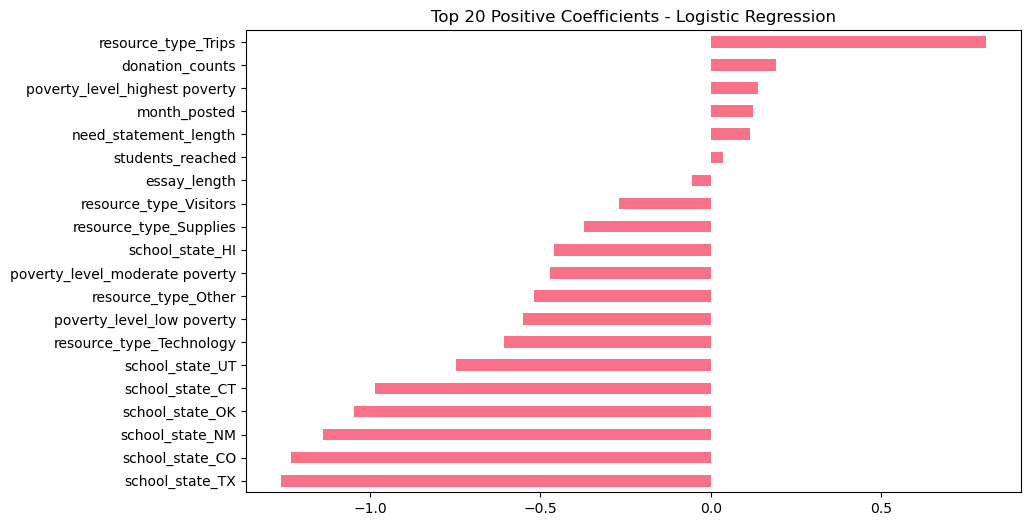

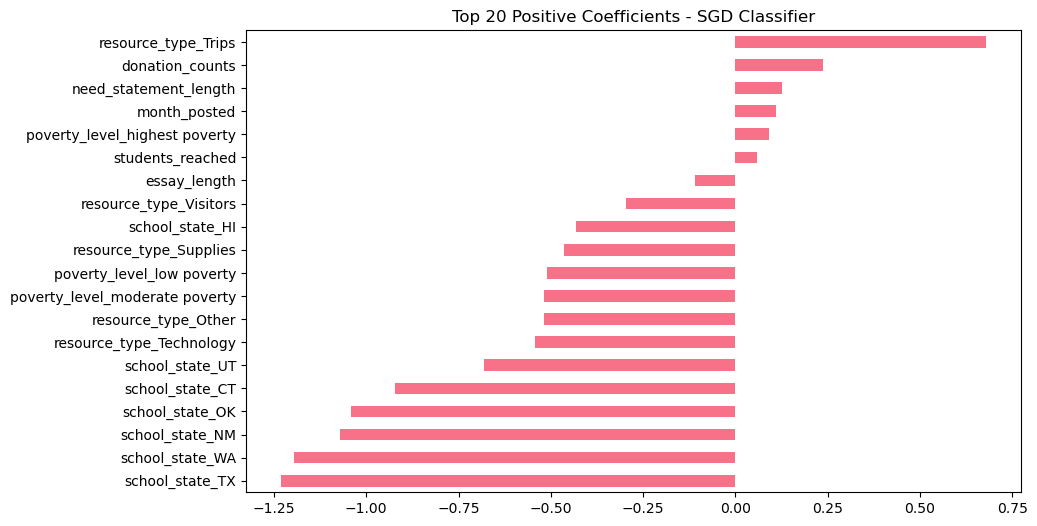

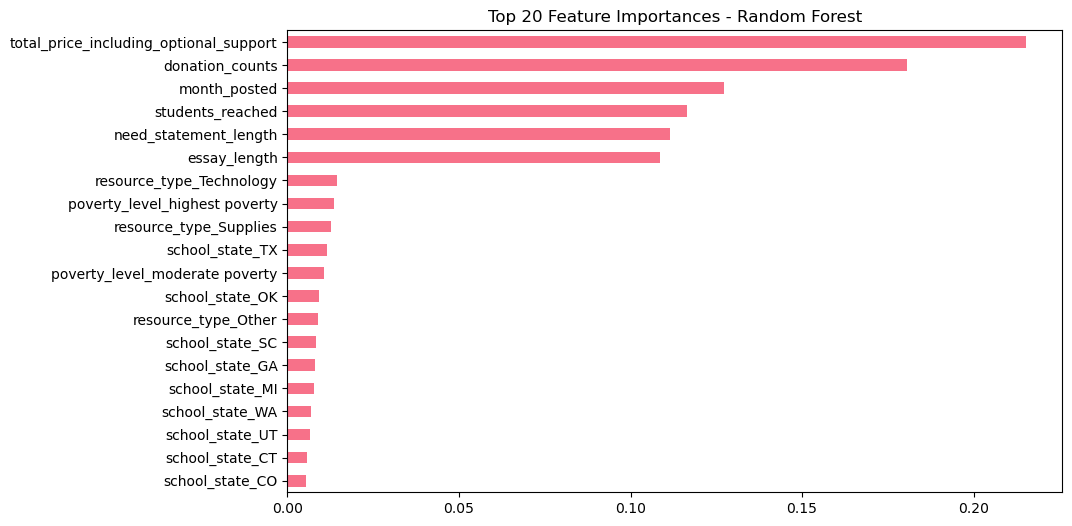

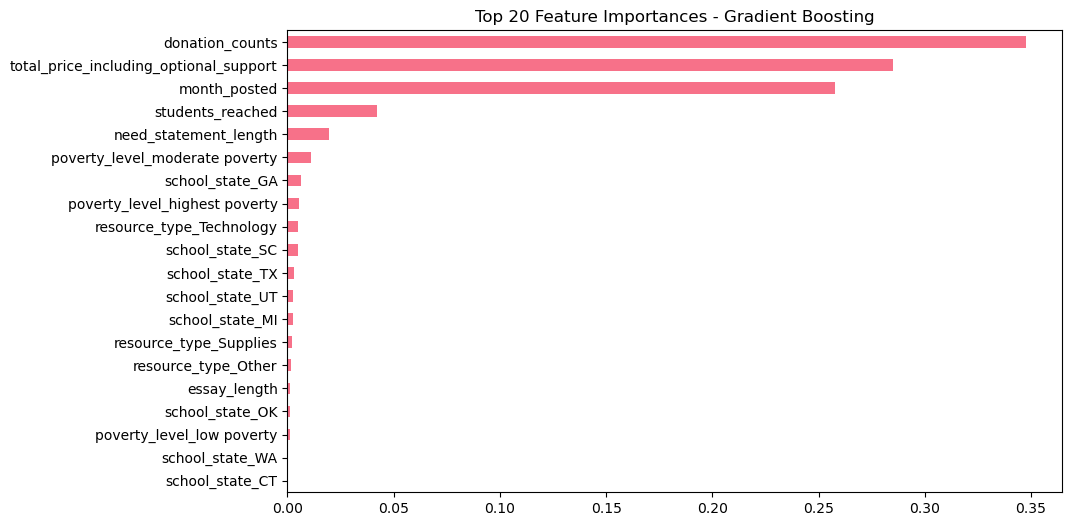

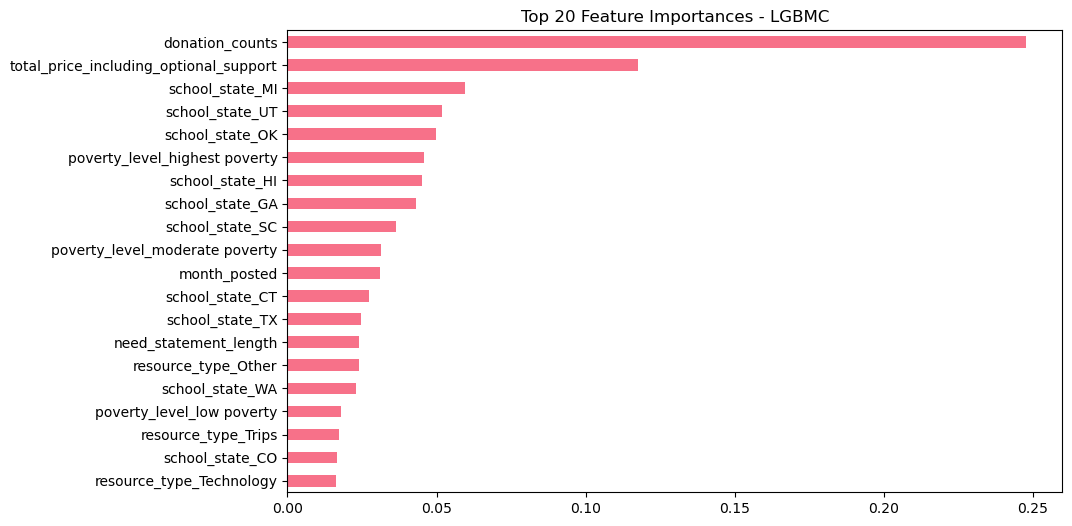

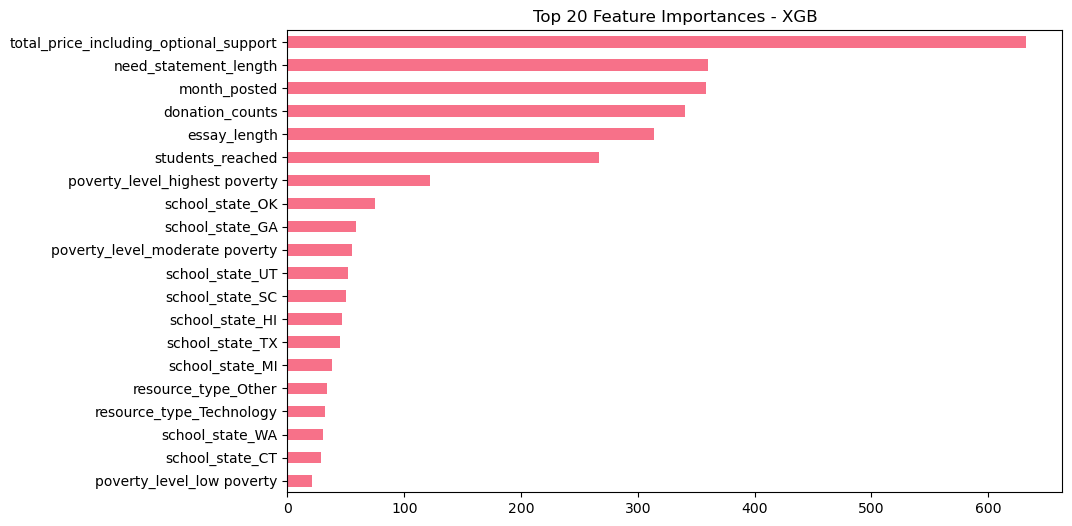

In [126]:
# ==================== FEATURE IMPORTANCE ====================
# Logistic Regression
lr_importance = pd.DataFrame(lr.coef_[0], index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
lr_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Positive Coefficients - Logistic Regression")
plt.show()

# SGD
sgd_importance = pd.DataFrame(sgd.coef_[0], index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
sgd_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Positive Coefficients - SGD Classifier")
plt.show()

# Random Forest
rf_importance = pd.DataFrame(rf.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
rf_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()

# Gradient Boosting
gb_importance = pd.DataFrame(gb.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
gb_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - Gradient Boosting")
plt.show()

# XGBoosting
xg_importance = pd.DataFrame(xg.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
xg_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - LGBMC")
plt.show()

#Light Gradient Boosting Machine
lg_importance = pd.DataFrame(lg.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
lg_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - XGB")
plt.show()


## Feature Importance Highlights

### 1. Logistic Regression
- **Most positively associated with success:**
  - `school_state_HI`, `school_state_NH`, `school_state_DC`
  - `poverty_level_highest poverty`
- Strong presence of **school_state** dummy variables shows that **geographic location** has high predictive power in linear separation.
- Also, `need_statement_length` appears to be relevant.

---

### 2. SGD Classifier
- Similar to Logistic Regression, but with **`resource_cost_sum`** as the top coefficient.
- High variance in coefficients (e.g., 1.2 for resource cost), possibly due to **regularization differences**.
- **State features** and `need_statement_length` are again **prominent**.

---

### 3. Random Forest
- **Top features:**
  - `total_price_including_optional_support`
  - `resource_cost_sum`
  - `essay_length`, `need_statement_length`, `students_reached`
- Tree-based models focus more on **numeric and continuous features**.
- **School states** and **poverty level dummies** rank lower — likely due to less consistent impact across decision splits.

---

### 4. Gradient Boosting
- **Dominated by**: `total_price_including_optional_support` (massively high importance)
- Next most important:
  - `need_statement_length`
  - `poverty_level_highest poverty`
  - A few `school_state` variables
- Suggests that **cost** and **poverty severity** are especially powerful when boosting decision trees.


 ## So I think include Poverty Level, essay/need statement length, cost features. Don't include state, or focus on specific state.



In [127]:
# Get predicted probability of being funded (1 = funded)
full_probs = gb.predict_proba(X_encoded)[:, 1]

# Attach predictions to your original model dataframe
df_model['predicted_prob'] = full_probs
df_model['projectid'] = df.loc[df_model.index, 'projectid']  # attach project ID back

# Sort by lowest predicted probability (least likely to be funded)
df_ranked = df_model.sort_values(by='predicted_prob', ascending=True)

# Select bottom 10%
cutoff = int(len(df_ranked) * 0.10)
bottom_10 = df_ranked.head(cutoff)


bottom_10[['projectid', 'predicted_prob']].to_csv('projects_for_expert_review.csv', index=False)
print(bottom_10[['projectid', 'predicted_prob']].head(10))


                               projectid  predicted_prob
621319  068ea2bb223234ad6d32ad812df61e04        0.122599
532863  59712422994b01aacc609776e589d03b        0.125398
359512  7e919d7a891ff3613d2e1b443bc37e45        0.127095
146091  1170f2633176a8dc5c85751beccf6992        0.127095
621550  1d08de88aa6d87f0103a3a12cce7b660        0.127141
578479  7745e230a184bad9ec206ab3bae5ac27        0.127141
621508  f1bac00c539547b959ec00783c552c0d        0.127141
154868  afdf43468c601d68a133baa130bec92b        0.128708
621552  1828c840fd165c8787fe23a7955bd306        0.129994
621622  6808547efdba60757d4d7fcbf416fd86        0.130028


In [128]:
# ==================== EVALUATION ====================
y_probs = {
    'Logistic Regression': lr.predict_proba(X_test)[:, 1],
    'Random Forest': rf.predict_proba(X_test)[:, 1],
    'Gradient Boosting': gb.predict_proba(X_test)[:, 1],
    'SGD Classifier': sgd.predict_proba(X_test)[:, 1],
    'KNN': knn.predict_proba(X_test)[:, 1],
    'XGBoosting': xg.predict_proba(X_test)[:, 1],
    'LGBMC': lg.predict_proba(X_test)[:, 1]
}

results = pd.DataFrame({
    'Model': list(y_probs.keys()),
    'ROC AUC': [roc_auc_score(y_test, prob) for prob in y_probs.values()]
})
print(results)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

for model_name, y_prob in y_probs.items():
    y_pred = (y_prob >= 0.5).astype(int)
    print(f"\n{model_name} Classification Report (focus on not-funded projects):")
    print(classification_report(y_test, y_pred, target_names=['Not Funded', 'Funded']))

    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)

    print(f"Precision (Not Funded): {precision:.3f}")
    print(f"Recall (Not Funded): {recall:.3f}")
    print(f"F1 Score (Not Funded): {f1:.3f}")



                 Model   ROC AUC
0  Logistic Regression  0.751893
1        Random Forest  0.810880
2    Gradient Boosting  0.794446
3       SGD Classifier  0.756516
4                  KNN  0.687666
5           XGBoosting  0.818661
6                LGBMC  0.820009

Logistic Regression Classification Report (focus on not-funded projects):
              precision    recall  f1-score   support

  Not Funded       0.34      0.72      0.46      4498
      Funded       0.91      0.66      0.77     18686

    accuracy                           0.67     23184
   macro avg       0.62      0.69      0.61     23184
weighted avg       0.80      0.67      0.71     23184

Precision (Not Funded): 0.338
Recall (Not Funded): 0.717
F1 Score (Not Funded): 0.460

Random Forest Classification Report (focus on not-funded projects):
              precision    recall  f1-score   support

  Not Funded       0.48      0.50      0.49      4498
      Funded       0.88      0.87      0.88     18686

    accuracy   

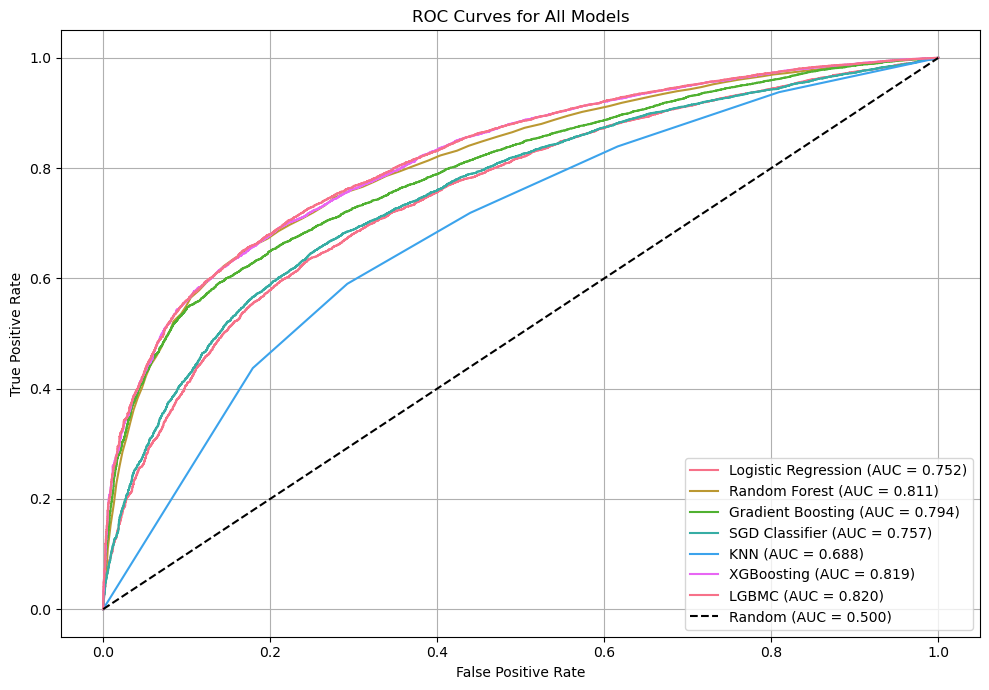

In [129]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 7))

for model_name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [130]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Get predicted labels (using default threshold = 0.5)
y_preds = {
    'Logistic Regression': lr.predict(X_test),
    'Random Forest': rf.predict(X_test),
    'Gradient Boosting': gb.predict(X_test),
    'SGD Classifier': sgd.predict(X_test),
    'KNN': knn.predict(X_test),
    'XGBoosting': xg.predict(X_test),
    'LGBMC': lg.predict(X_test)
}

metrics = []

for model_name, y_pred in y_preds.items():
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)
    metrics.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc_score(y_test, y_probs[model_name])
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df.sort_values(by='F1-score', ascending=False))


                 Model  Precision    Recall  F1-score       AUC
6                LGBMC   0.377970  0.795687  0.512494  0.820009
5           XGBoosting   0.378244  0.793908  0.512375  0.818661
1        Random Forest   0.476725  0.510004  0.492803  0.810880
2    Gradient Boosting   0.388557  0.664295  0.490318  0.794446
3       SGD Classifier   0.347265  0.718542  0.468236  0.756516
0  Logistic Regression   0.338479  0.716541  0.459772  0.751893
4                  KNN   0.324286  0.560471  0.410854  0.687666


---

# We saw that the LGMC and XGBoosting model has been performing the best, so now we will be focusing on making the performances of these models better 

### Current Issues With Our Baseline Model Performance: We have decent recall but the precison is not that good. So now our hyperparameter tuning and fetaure engineering would be based around making the precision better better so our overall model performance improves.  